# Abalone XGBoost + SageMaker Debugger


## Overview

Amazon SageMaker Debugger is a new capability of Amazon SageMaker that allows debugging machine learning training. 
Amazon SageMaker Debugger helps you to monitor your training in near real time using rules and would provide you alerts, once it has detected inconsistency in training. 

Using Amazon SageMaker Debugger is a two step process: Saving tensors and Analysis.
Let's look at each one of them closely.

### Saving tensors

In deep learning algorithms, tensors define the state of the training job at any particular instant in its lifecycle.
Amazon SageMaker Debugger exposes a library which allows you to capture these tensors and save them for analysis.
Although XGBoost is not a deep learning algorithm, Amazon SageMaker Debugger is highly customizable and can help provide interpretability by saving insightful metrics, such as performance metrics or feature importances, at different frequencies.
Refer to [documentation](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/xgboost.md) for details on how to save the metrics you want.


### Analysis

After the tensors are saved, perform automatic analysis by running debugging ***[Rules](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html)***.
On a very broad level, a rule is Python code used to detect certain conditions during training.
Some of the conditions that a data scientist training an algorithm may care about are monitoring for gradients getting too large or too small, detecting overfitting, and so on.
Amazon SageMaker Debugger comes pre-packaged with certain rules that can be invoked on Amazon SageMaker. Users can also write their own rules using the Amazon SageMaker Debugger APIs. 
For more information about automatic analysis using a rule, see the [rules documentation](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/analysis.md).

## Setup

In [ ]:
! python -m pip install smdebug

In [7]:
import sagemaker
import boto3

Amazon SageMaker Debugger is available in Amazon SageMaker XGBoost container version 0.90-2 or later. If you want to use XGBoost with Amazon SageMaker Debugger, you have to specify `repo_version='0.90-2'` in the `get_image_uri` function.

In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri

# Below changes the Region to be one where this notebook is running
region = boto3.Session().region_name

container = get_image_uri(region, 'xgboost', repo_version='0.90-2')

## Data preparation

Use the [Abalone data](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html) originally from the [UCI data repository](https://archive.ics.uci.edu/ml/datasets/abalone).
More details about the original dataset can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names).
In the libsvm converted [version](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html), the nominal feature (Male/Female/Infant) has been converted into a real valued feature.
Age of abalone is to be predicted from eight physical measurements.

Following methods download the Abalone data, split the data into training and validation
sets, and upload files to Amazon Simple Storage Service (Amazon S3).

In [12]:
from data_utils import load_abalone, upload_to_s3

bucket = sagemaker.Session().default_bucket()
prefix = "DEMO-smdebug-xgboost-abalone"

In [13]:
train_file, validation_file = load_abalone()
upload_to_s3(train_file, bucket, f"{prefix}/train/abalone.train.libsvm")
upload_to_s3(validation_file, bucket, f"{prefix}/validation/abalone.validation.libsvm")

Writing to s3://sagemaker-us-east-1-892313895307/DEMO-smdebug-xgboost-abalone/train/abalone.train.libsvm
Writing to s3://sagemaker-us-east-1-892313895307/DEMO-smdebug-xgboost-abalone/validation/abalone.validation.libsvm


In [19]:
from sagemaker import get_execution_role

role = get_execution_role()
base_job_name = "demo-smdebug-xgboost-classification"
bucket_path = 's3://{}'.format(bucket)

hyperparameters={
    "max_depth": "5",
    "eta": "0.9",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.7",
    "silent": "0",
    "objective": "reg:squarederror",
    "num_round": "51",
}

save_interval = 5

base_job_name = "demo-smdebug-xgboost-regression"

## Enable Debugger in Estimator 

### DebuggerHookConfig

Enabling Amazon SageMaker Debugger in training job can be accomplished by adding its configuration into Estimator object constructor:

```python
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig

estimator = Estimator(
    ...,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path="s3://{bucket_name}/{location_in_bucket}",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "10"
                }
            )
        ]
    )
)
```
Here, the `DebuggerHookConfig` object instructs `Estimator` what data we are interested in.
Two parameters are provided in the example:

- `s3_output_path`: it points to S3 bucket/path where we intend to store our debugging tensors.
  Amount of data saved depends on multiple factors, major ones are: training job / data set / model / frequency of saving tensors.
  This bucket should be in your AWS account, and you should have full access control over it.
  **Important Note**: this s3 bucket should be originally created in the same region where your training job will be running, otherwise you might run into problems with cross region access.

- `collection_configs`: it enumerates named collections of tensors we want to save.
  Collections are a convinient way to organize relevant tensors under same umbrella to make it easy to navigate them during analysis.
  In this particular example, you are instructing Amazon SageMaker Debugger that you are interested in a single collection named `metrics`.
  We also instructed Amazon SageMaker Debugger to save metrics every 10 iteration.
  See [Collection](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/api.md#collection) documentation for all parameters that are supported by Collections and DebuggerConfig documentation for more details about all parameters DebuggerConfig supports.
  
### Rules

Enabling Rules in training job can be accomplished by adding the `rules` configuration into Estimator object constructor.

- `rules`: This new parameter will accept a list of rules you wish to evaluate against the tensors output by this training job.
  For rules, Amazon SageMaker Debugger supports two types:
  - SageMaker Rules: These are rules specially curated by the data science and engineering teams in Amazon SageMaker which you can opt to evaluate against your training job.
  - Custom Rules: You can optionally choose to write your own rule as a Python source file and have it evaluated against your training job.
    To provide Amazon SageMaker Debugger to evaluate this rule, you would have to provide the S3 location of the rule source and the evaluator image.

In this example, you will use a Amazon SageMaker's LossNotDecreasing rule, which helps you identify if you are running into a situation where the training loss is not going down.

```python
from sagemaker.debugger import rule_configs, Rule

estimator = Estimator(
    ...,
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ],
)
```

- `rule_parameters`: In this parameter, you provide the runtime values of the parameter in your constructor.
  You can still choose to pass in other values which may be necessary for your rule to be evaluated.
  In this example, you will use Amazon SageMaker's LossNotDecreasing rule to monitor the `metircs` collection.
  The rule will alert you if the tensors in `metrics` has not decreased for more than 10 steps.

In [20]:
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
from sagemaker.estimator import Estimator


algorithm_mode_default_estimator = Estimator(
    role=role,
    base_job_name=base_job_name,
    train_instance_count=1,
    train_instance_type='ml.m5.xlarge',
    image_name=container,
    hyperparameters=hyperparameters,
    train_max_run=1800,

    debugger_hook_config=DebuggerHookConfig(
        s3_output_path=bucket_path,  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="feature_importance",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="average_shap",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
        ],
    ),

    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": str(save_interval * 2),
            },
        ),
    ],
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


With the next step, start a training job by using the Estimator object you created above. This job is started in an asynchronous, non-blocking way. This means that control is passed back to the notebook and further commands can be run while the training job is progressing.

In [21]:
from sagemaker.session import s3_input

train_s3_input = s3_input("s3://{}/{}/{}".format(bucket, prefix, "train"), content_type="libsvm")
validation_s3_input = s3_input( "s3://{}/{}/{}".format(bucket, prefix, "validation"), content_type="libsvm")
algorithm_mode_default_estimator.fit(
    {"train": train_s3_input, "validation": validation_s3_input},
    # This is a fire and forget event. By setting wait=False, you just submit the job to run in the background.
    # Amazon SageMaker starts one training job and release control to next cells in the notebook.
    # Follow this notebook to see status of the training job.
    wait=False
)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


### Check Status of Training Job

As a result of the above command, Amazon SageMaker starts one training job and one rule job for you. The first one is the job that produces the tensors to be analyzed. The second one analyzes the tensors to check if `train-rmse` and `validation-rmse` are not decreasing at any point during training.

Check the status of the training job below.
After your training job is started, Amazon SageMaker starts a rule-execution job to run the LossNotDecreasing rule.

**Note that the next cell blocks until the rule execution job ends. You can stop it at any point to proceed to the rest of the notebook. Once it says Rule Evaluation Status is Started, and shows the `RuleEvaluationJobArn`, you can look at the status of the rule being monitored.**

In [22]:
import time

for _ in range(360):
    job_name = algorithm_mode_default_estimator.latest_training_job.name
    client = algorithm_mode_default_estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = algorithm_mode_default_estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print("Training job status: {}, Rule Evaluation Status: {}".format(training_job_status, rule_evaluation_status))

    if rule_evaluation_status in ["Stopped", "IssuesFound", "NoIssuesFound"]:
        break

    time.sleep(10)

Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation

### Check Status of Rule Evaluation Job

To get the rule evaluation job that Amazon SageMaker started for you, run the command below. The results show you the `RuleConfigurationName`, `RuleEvaluationJobArn`, `RuleEvaluationStatus`, `StatusDetails`, and `RuleEvaluationJobArn`.
If the tensors meets a rule evaluation condition, the rule execution job throws a client error with `RuleEvaluationConditionMet`.

The logs of the rule evaluation job are available in the Cloudwatch Logstream `/aws/sagemaker/ProcessingJobs` with `RuleEvaluationJobArn`.

You can see that once the rule execution job starts, it identifies the loss not decreasing situation in the training job, it raises the `RuleEvaluationConditionMet` exception, and it ends the job.

In [23]:
algorithm_mode_default_estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:892313895307:processing-job/demo-smdebug-xgboost-regre-lossnotdecreasing-7b137f34',
  'RuleEvaluationStatus': 'IssuesFound',
  'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule LossNotDecreasing at step 30 resulted in the condition being met\n',
  'LastModifiedTime': datetime.datetime(2020, 8, 25, 1, 50, 53, 641000, tzinfo=tzlocal())}]

### Making this a good run

In previous example, you saw how a LossNotDecreasing rule was run that analyzed the tensors when training was running and produced an alert.

You can go back and change the hyperparameters passed to the estimator to `hyperparameters` and start a new training job (e.g., use a smaller learning rate `eta=0.05`). You can see that the LossNotDecreasing rule is not fired in that case as both `train-rmse` and `validation-rmse` keep decreasing steadily throughout the entire training duration.

## Data Analysis

Now that you've trained the system, analyze the data.
Here, you focus on after-the-fact analysis.

You import a basic analysis library, which defines the concept of trial, which represents a single training run.

In [24]:
from smdebug.trials import create_trial

s3_output_path = algorithm_mode_default_estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2020-08-25 01:52:26.693 ip-172-16-112-122:32045 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-892313895307/demo-smdebug-xgboost-regression-2020-08-25-01-44-44-489/debug-output


You can list all the tensors that you know something about. Each one of these names is the name of a tensor. The name is a combination of the feature name, which in these cases, is auto-assigned by XGBoost, and whether it's an evaluation metric, feature importance, or SHAP value.

In [25]:
trial.tensor_names()

['average_shap/f0',
 'average_shap/f1',
 'average_shap/f2',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'feature_importance/cover/f1',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_importance/cover/f6',
 'feature_importance/cover/f7',
 'feature_importance/cover/f8',
 'feature_importance/gain/f1',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_importance/gain/f4',
 'feature_importance/gain/f5',
 'feature_importance/gain/f6',
 'feature_importance/gain/f7',
 'feature_importance/gain/f8',
 'feature_importance/total_cover/f1',
 'feature_importance/total_cover/f2',
 'feature_importance/total_cover/f3',
 'feature_importance/total_cover/f4',
 'feature_importance/total_cover/f5',
 'feature_importance/total_cover/f6',
 'feature_importance/total_cover/f7',
 'feature_importance/total_cover/f8',
 'feature_im

For each tensor, ask for the steps where you have data. In this case, every five steps

In [26]:
trial.tensor("train-rmse").steps()

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

You can obtain each tensor at each step as a NumPy array.

In [28]:
trial.tensor("train-rmse").value(10)

array([1.859705])

### Performance metrics

You can also create a simple function that visualizes the training and validation errors as the training progresses.
Each gradient should get smaller over time, as the system converges to a good solution.
Remember that this is an interactive analysis. You are showing these tensors to give an idea of the data.

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import re


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()

    tensors = trial.collection(collection_name).tensor_names

    for tensor_name in sorted(tensors):
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            ax.plot(steps, data, label=tensor_name)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

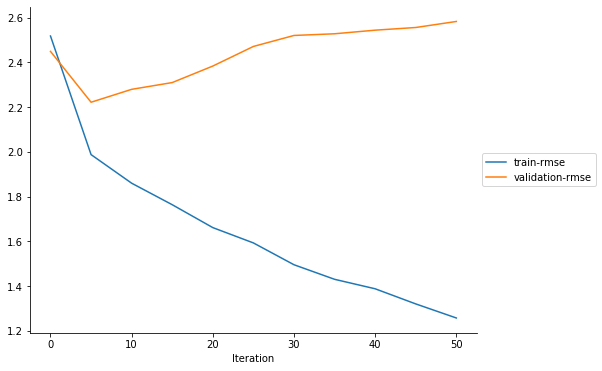

In [30]:
plot_collection(trial, "metrics")

### Feature importances

You can also visualize the feature priorities as determined by
[xgboost.get_score()](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score).
If you instructed Estimator to log the `feature_importance` collection, all five importance types supported by `xgboost.get_score()` will be available in the collection.

In [31]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")

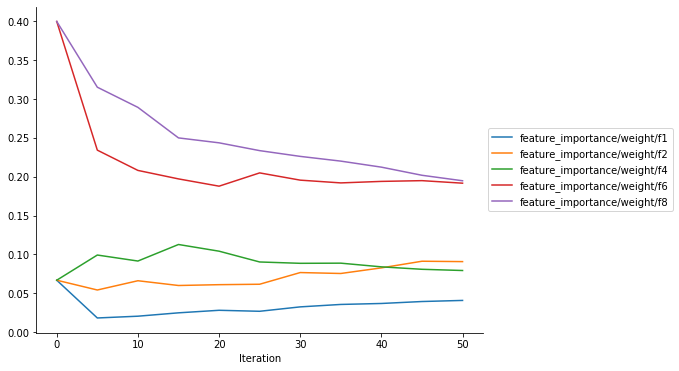

In [32]:
plot_feature_importance(trial)

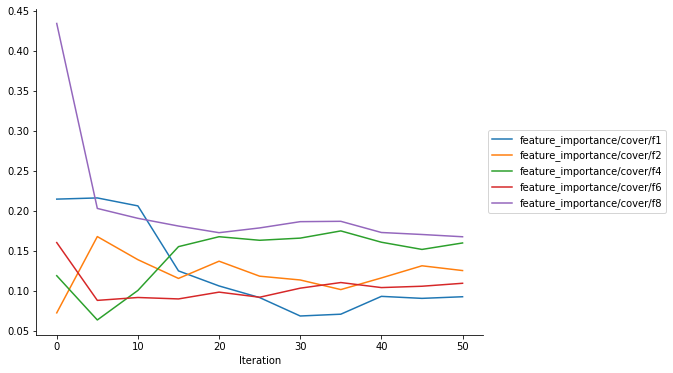

In [33]:
plot_feature_importance(trial, importance_type="cover")

### SHAP

[SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) is
another approach to explain the output of machine learning models.
SHAP values represent a feature's contribution to a change in the model output.
You instructed Estimator to log the average SHAP values in this example so the SHAP values (as calculated by [xgboost.predict(pred_contribs=True)](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.predict)) will be available the `average_shap` collection.

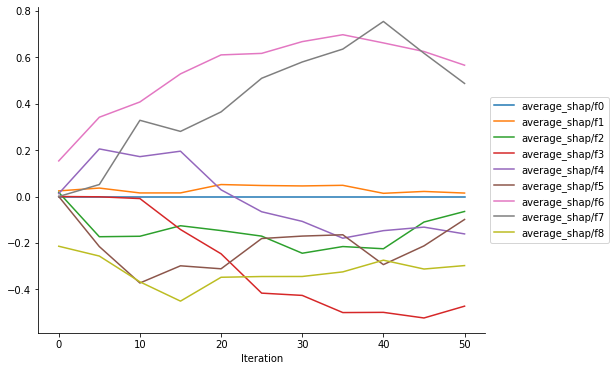

In [34]:
plot_collection(trial, "average_shap")